### 📦 1. Load and Preprocess Data
We load the processed user features, select relevant churn-related features, perform train-test split, and standardize the data.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Paths
project_root = Path.cwd().parent
data_path = project_root / "data" / "processed" / "user_features_expanded.csv"
vis_dir = project_root / "outputs" / "MLP_Visuals"
vis_dir.mkdir(parents=True, exist_ok=True)

# Load and select features
df = pd.read_csv(data_path)
features = [
    'avg_time', 'total_time', 'session_count',
    'first_day', 'last_day',
    'session_type_lesson', 'session_type_practice', 'session_type_test',
    'client_android', 'client_web', 'client_ios'
]
X = df[features]
y = df['churned'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 🧠 2. Define and Train the MLP Model
We define a 2-layer dense neural network with dropout regularization. Early stopping is applied to prevent overfitting.


In [17]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
# Save the trained model as mlp_model for later evaluation
mlp_model = model


Epoch 1/50
65/65 [==============================] - 2s 7ms/step - loss: 0.6183 - accuracy: 0.6807 - val_loss: 0.5185 - val_accuracy: 0.7829
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.4745 - accuracy: 0.8028 - val_loss: 0.4136 - val_accuracy: 0.8043
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.4108 - accuracy: 0.8120 - val_loss: 0.3895 - val_accuracy: 0.8275
Epoch 4/50
65/65 [==============================] - 1s 11ms/step - loss: 0.3846 - accuracy: 0.8338 - val_loss: 0.3772 - val_accuracy: 0.8391
Epoch 5/50
65/65 [==============================] - 0s 5ms/step - loss: 0.3755 - accuracy: 0.8367 - val_loss: 0.3736 - val_accuracy: 0.8333
Epoch 6/50
65/65 [==============================] - 1s 8ms/step - loss: 0.3727 - accuracy: 0.8348 - val_loss: 0.3698 - val_accuracy: 0.8353
Epoch 7/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3674 - accuracy: 0.8333 - val_loss: 0.3661 - val_accuracy: 0.8391
Epoch 8/50
65/65 [=

### 📈 3. Accuracy & Loss Curves
Visualizing model performance over epochs gives insights into training dynamics and overfitting.


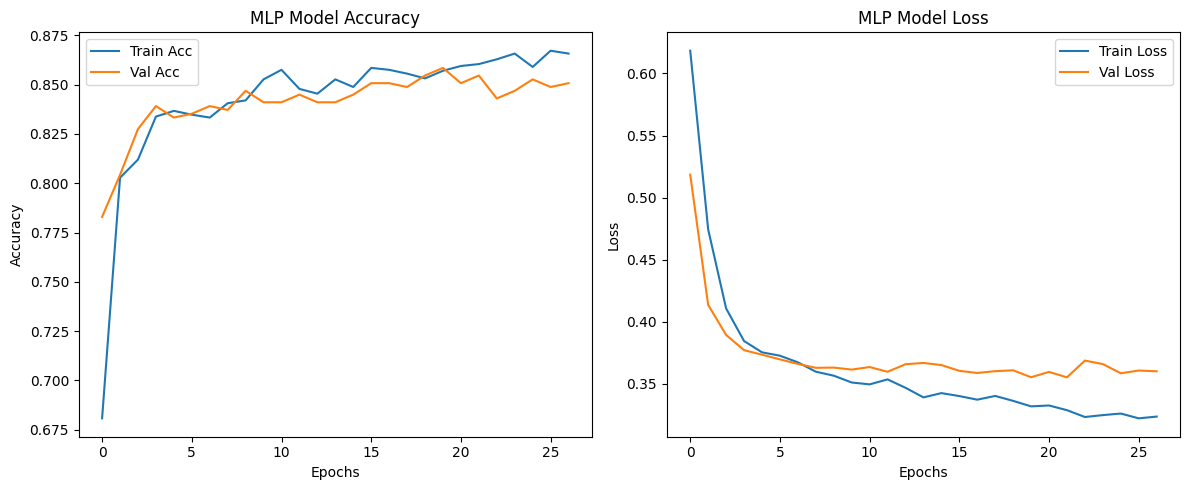

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('MLP Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(vis_dir / "mlp_accuracy_loss.png")
plt.show()


### 🔍 4. Evaluate MLP Model
We generate predictions, confusion matrix, classification report, and ROC-AUC score to evaluate MLP performance.


17/17 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

 Not Churned       0.79      0.82      0.80       187
     Churned       0.89      0.88      0.88       329

    accuracy                           0.85       516
   macro avg       0.84      0.85      0.84       516
weighted avg       0.86      0.85      0.86       516



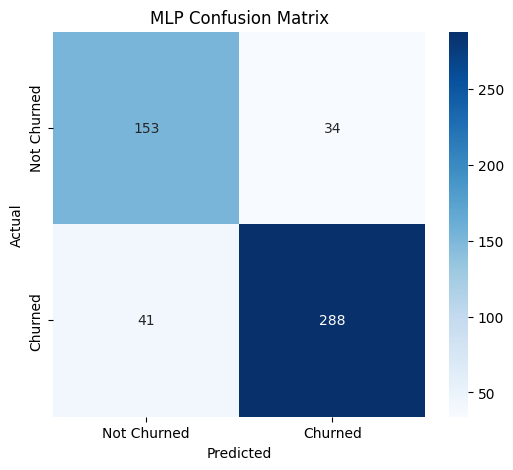

In [19]:
# Predict
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix and classification report
print(classification_report(y_test, y_pred, target_names=["Not Churned", "Churned"]))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(vis_dir / "mlp_confusion_matrix.png")
plt.show()


### 📉 5. ROC Curve & AUC
We plot the ROC curve and calculate the AUC score to evaluate the classifier’s ability to distinguish classes.


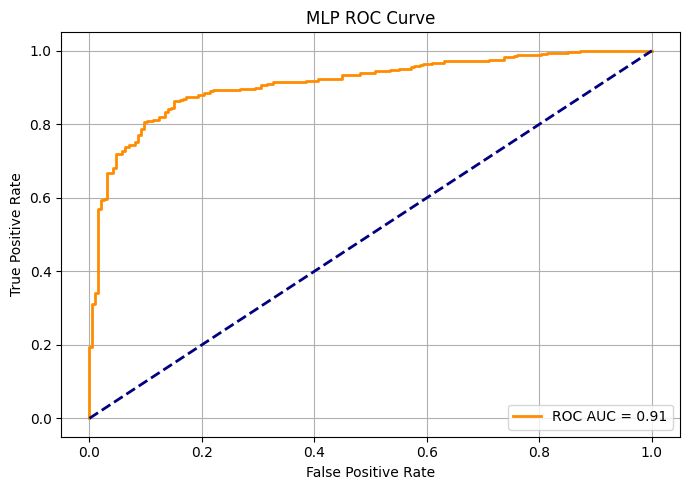

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(vis_dir / "mlp_roc_curve.png")
plt.show()


### 📊 Final Evaluation – MLP Model

This cell prints the final accuracy and AUC score of the MLP model on the test set.
These metrics help assess the model's overall performance in classifying churned and non-churned users.


In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 🔮 Predict probabilities for the positive class (churned = 1)
y_pred_probs = mlp_model.predict(X_test_scaled).flatten()


# 🎯 Predict class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# ✅ Calculate final test accuracy
mlp_test_acc = accuracy_score(y_test, y_pred) * 100

# 📊 Calculate AUC score
mlp_auc_score = roc_auc_score(y_test, y_pred_probs) * 100

# 📢 Print both results
print(f"✅ Final MLP Test Accuracy: {mlp_test_acc:.2f}%")
print(f"📈 Final MLP ROC AUC Score: {mlp_auc_score:.2f}%")


17/17 [==============================] - 0s 2ms/step
✅ Final MLP Test Accuracy: 85.47%
📈 Final MLP ROC AUC Score: 91.17%


### 📌 MLP Summary and Insights

- ✅ MLP achieved stable accuracy and loss with early stopping.
- 🔍 Confusion matrix shows decent balance between churn and retention predictions.
- 📈 ROC AUC indicates reasonable class separation performance.
- 📊 This model provides a strong non-sequential DL baseline, ideal for structured data.
